Se escogen dos clasificadores para un problema `Multi-class`:
- Logistic Regression
- Random Forest

El dataset de clasificación será:
- Iris dataset

## Importing Libraries

In [4]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset

In [3]:
iris_dataset = fetch_ucirepo(id=53)
X_iris = iris_dataset.data.features
y_iris = iris_dataset.data.targets['class']
iris_df = pd.concat([X_iris, y_iris], axis=1)

Let's visualize the class proportions in the `Iris dataset`

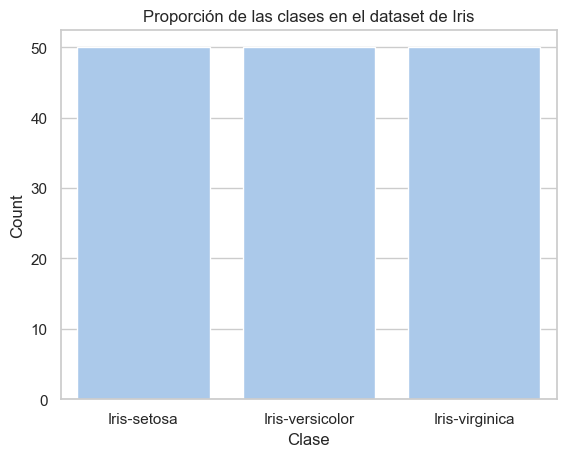

In [14]:
sns.set(style="whitegrid", palette="pastel")
sns.countplot(x='class', data=iris_df)
plt.xlabel("Clase")
plt.ylabel("Count")
plt.title("Proporción de las clases en el dataset de Iris")
plt.show()

El dataset tiene un balanceo perfecto, donde cada clase contiene el mismo número de instancias